### Applied Statistical analysis of Ethereum (ETH) time series
This notebook will cover a statistical analysis of the Ethereum (ETH) price series, conducting a maximum likelihood estimation, moments and examining the tails of the distribution. Furthermore, the dataset will be fitted through a body-tail fit, therefore having two different distributions fitted for its body and tails. 

In [32]:
#Data imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import erf
import scipy.optimize
plt.style.use('ggplot')
%matplotlib inline

Text(0.5, 1.0, 'Time Series of ETH price')

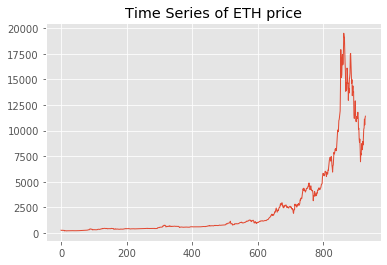

In [4]:
df = pd.read_csv('crypto_prices.txt', sep=',', header=None)
btc = df[0] #selecting bitcoin as the cryptocurrency to analyse
plt.plot(btc, linewidth=1)
plt.title('Time Series of ETH price')

We will be utilising logarithmic returns as they result in a slightly more stationary time series, which is then easier to be analysed statistically. This is computed as follows:
$$\ln\left(\frac{P_{t+1}}{P_{t}}\right)$$

Text(0.5, 1.0, 'Log-returns for ETH')

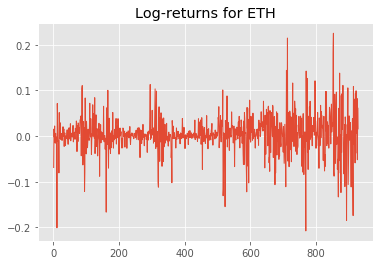

In [5]:
log_ret = np.log(btc/btc.shift(1)).dropna()
plt.plot(log_ret, linewidth=1)
plt.title('Log-returns for ETH')

We are creating a function to output an aggregated version of the returns so we can view a time series which is less noisy of the original one, as an example in this next script a weekly return is computed

Text(0.5, 1.0, 'Aggregated returns for BTC for 2 days')

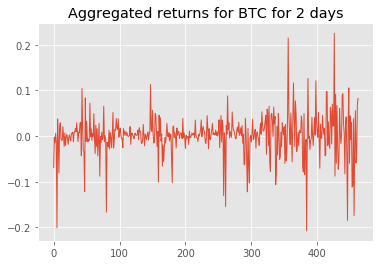

In [6]:
#A function to aggregate returns over a longer period of time
def aggregate_returns(returns, n_days=7):
    aux = np.array([])
    count = 0
    for t in np.arange(0, len(returns)-n_days, n_days):
        aux = np.append(aux,np.sum(returns[np.arange(t+1,t+n_days)]))
        count += 1
    return aux

aggregation = 2
r = aggregate_returns(log_ret, n_days=aggregation)

plt.plot(r, linewidth=1)
plt.title('Aggregated returns for BTC for {} days'.format(aggregation))

We are now computing the four important moments of the distribution.\
- Mean (first moment):
$$\mu = \mathop{\mathbb{E}}[r]$$
- Standard deviation (second moment about the mean):
$$\sigma^2 = \mathop{\mathbb{E}}[(r-\mu)^2]$$
- Skewness (third moment about the mean - scaled):
$$\xi = \frac{1}{\sigma^3}\mathop{\mathbb{E}}[(r-\mu)^3]$$
- Kurtosis (fourth moment about the mean - scaled):
$$\kappa = \frac{1}{\sigma^4}\mathop{\mathbb{E}}[(r-\mu)^4]$$


In [7]:
#Manually computing moments
N = len(r)
mu = np.sum(r)/N #mean
sigma = np.sqrt(np.sum((r-mu)**2)/N) #standard deviation
xi = np.sum((r-mu)**3)/(N*sigma**3) #skewness
kappa = np.sum((r-mu)**4)/(N*sigma**4) #kurtosis
print('Mean = {} \nStandard deviation = {} \nSkewness = {} \nKurtosis = {}'.format(mu, sigma, xi, kappa))

Mean = 0.001859273451101638 
Standard deviation = 0.04423288439099508 
Skewness = -0.5087256260446239 
Kurtosis = 8.978585689732874


We will now plot the empirical PDF versus a Gaussian to examine the differences (especially in the tails of the distribution). We expect to observe fatter tails in the empirical distribution.

Text(0.5, 1.0, 'CCDF')

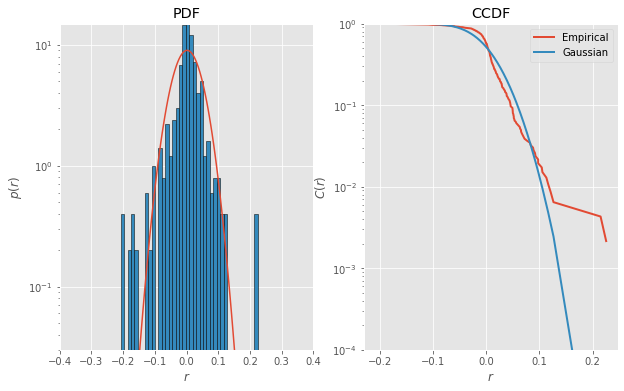

In [8]:
x = np.linspace(np.min(r),np.max(r),100)
f = np.exp(-(x-mu)**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2) #analytical pdf for Gaussian distribution

fig, ax = plt.subplots(1,2, figsize=(10,6))

bins = 40
ax[0].plot(x,f)
ax[0].hist(r, density=True, bins=bins, edgecolor='k')
ax[0].set_yscale('log', nonposy='clip') #log-transforming the y axis
ax[0].set_xlim([-0.4, 0.4])
ax[0].set_ylim([0.03, 15])
ax[0].set_xlabel(r'$r$')
ax[0].set_ylabel(r'$p(r)$')
ax[0].set_title('PDF')

sorted_r = np.sort(r) #sorting the array
y = np.arange(1, len(r)+1, 1)
y = 1 - y/(len(r)+1) #rank-frequency plot
c = 0.5*(1 - erf((sorted_r-mu)/(sigma*np.sqrt(2))))
ax[1].plot(sorted_r,y, linewidth=2, label='Empirical')
ax[1].plot(sorted_r,c, linewidth=2, label='Gaussian')
ax[1].set_yscale('log', nonposy='clip') #log-transforming the y axis
ax[1].set_ylim([1e-4,1])
ax[1].legend()
ax[1].set_xlabel(r'$r$')
ax[1].set_ylabel(r'$C(r)$')
ax[1].set_title('CCDF')

From the above plots we can clearly see a variation from normality, both in the PDF and the CDF

## Fitting the distribution tails
From the above results, we observed that we can simply not use a Gaussian distribution to fit this time series of returns, therefore we will have to fit the tails separately, through a power-law distribution:
$$p(r) = \frac{\alpha}{r_{min}}\left(\frac{r}{r_{min}}\right)^{-(\alpha + 1)} \;\;\; \textrm{for}\; r\in{[r_{min}, \infty]}$$
Solving for the optimal $\alpha$ using maximum likelihood estimation, we find the following:
$$\alpha^* = \frac{T}{ \sum_{i=1}^{T} \log\frac{r_i}{r_{min}}}$$
#### Parameter definitions:
$r_{min}$ - smallest value from which power-law behaviour starts (start of the tails)\
$\alpha$ - tail exponent (quantifies the behaviour in the tail), the smaller the value, the more extreme power-law behaviour observed\
T - length of vector


In [9]:
p = 0.1 #we are fitting the top p % of returns (assuming tail occurs in top and bottom 10%)
r = np.sort(r) #sorting return vector
r_r = r[int(np.round((1-p)*len(r))):-1] #extracting the top p% of returns
N = len(r_r)
alpha_r = N/np.sum(np.log(r_r/np.min(r_r))) #finding optimal alpha through maximum likelihood formula
print('The fitted alpha for the right tail is is {}'.format(alpha_r))

The fitted alpha for the right tail is is 2.442402673373541


Text(0.5, 1.0, 'Behaviour in the right tail of the distribution')

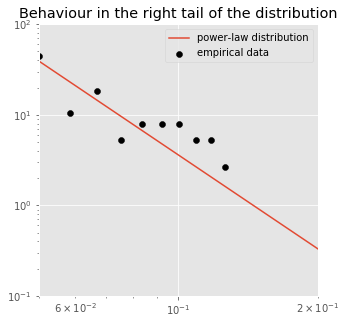

In [10]:
x_r = np.linspace(np.min(r_r), np.max(r_r), 100)
y_r = alpha_r/np.min(r_r)*(np.power(x_r/np.min(x_r), -(alpha_r+1))) #fitting the power-law distribution

h, base = np.histogram(r_r, bins=20, density=True)
base = 0.5*(base[1:]+base[:-1])

plt.figure(figsize=(5,5))
plt.scatter(base, h, color='black', label='empirical data', 
            marker='o')
plt.plot(x_r, y_r, label='power-law distribution')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylim([0.1, 100])
plt.xlim([0.05,0.2])
plt.title('Behaviour in the right tail of the distribution')

From this we can observe that the previously defined power-law distribution captures information in the tails of the distribution quite effectively. Let's now fit the left tail and observe if the behaviour is similar:

In [11]:
r_l = r[0:int(np.round(p*len(r)))] #extracting the bottom p% of returns
r_l = np.absolute(r_l)
N_l = len(r_l)
alpha_l = N_l/np.sum(np.log(r_l/np.min(r_l))) #finding optimal alpha through maximum likelihood formula
print('The fitted alpha for the left tail is is {}'.format(alpha_l))

The fitted alpha for the left tail is is 1.6120727356815447


The left tail has a lower alpha value, symbolising more extreme tail behaviour. This is expected because of what we saw examining the moments of the returns. The distribution appears to be skewed towards the left (i.e. more extreme negative returns are present than positive returns)

Text(0.5, 1.0, 'Behaviour in the left tail of the distribution')

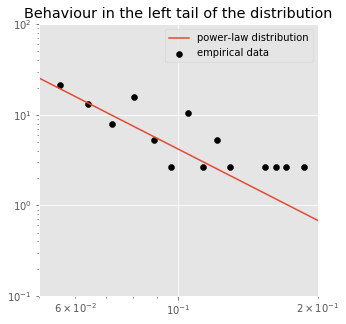

In [12]:
x_l = np.linspace(np.min(r_l), np.max(r_l), 100)
y_l = alpha_l/np.min(r_l)*(np.power(x_l/np.min(x_l), -(alpha_l+1))) #fitting the power-law distribution

h_l, base_l = np.histogram(r_l, bins=20, density=True)
base_l = 0.5*(base_l[1:]+base_l[:-1])

plt.figure(figsize=(5,5))
plt.scatter(base_l, h_l, color='black', label='empirical data', 
            marker='o')
plt.plot(x_l, y_l, label='power-law distribution')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylim([0.1, 100])
plt.xlim([0.05,0.2])
plt.title('Behaviour in the left tail of the distribution')

## Bootstrap estimation
We found estimates, however it is not important to find the level of the statistical uncertainty of such estimates, which will be carried through using bootstrap analysis (we will attach a confidence interval to each of the estimates). Boostrap analysis resamples the data to compute confidence intervals.

In [13]:
bts_retain = 0.8 #the amount of data kept in each resampling
n_sample = 500 #number of samples which will be conducted
confint = 0.9 #the confidence level we are trying to achieve (in this case 90%)
estimates_r = np.array([]) #collection of all the estimates in the right tail

for i in range(n_sample):
    r_sample = r[np.random.permutation(len(r))]
    r_sample = r_sample[0:int(np.round(bts_retain*len(r_sample)))] #bootstrapping % of returns
    r_sample = np.sort(r_sample)
    r_rightsample = r_sample[int(np.round((1-p)*len(r_sample))):-1]
    
    N_bts = len(r_rightsample)
    estimates_r = np.append(estimates_r,
                           N_bts/np.sum(np.log(r_rightsample/np.min(r_rightsample))))
estimates_r = np.sort(estimates_r)
print('Right tail interval at {} confidence: [{} - {}]'.format(confint, 
     estimates_r[int(np.round(0.5*(1-confint)*n_sample))],
     estimates_r[int(np.round(0.5*(1+confint)*n_sample))]))

Right tail interval at 0.9 confidence: [2.2719241957632397 - 2.944056454757116]


We can now do exactly the same for the left tail

In [14]:
estimates_l = np.array([]) #collection of all the estimates in the right tail

for i in range(n_sample):
    l_sample = r[np.random.permutation(len(r))]
    l_sample = l_sample[0:int(np.round(bts_retain*len(l_sample)))] #bootstrapping % of returns
    l_sample = np.sort(l_sample)
    r_leftsample = l_sample[0:int(np.round((p)*len(l_sample)))]
    r_leftsample = np.absolute(r_leftsample)
    
    N_bts = len(r_leftsample)
    estimates_l = np.append(estimates_l,
                           N_bts/np.sum(np.log(r_leftsample/np.min(r_leftsample))))
estimates_l = np.sort(estimates_l)
print('Right tail interval at {} confidence: [{} - {}]'.format(confint, 
     estimates_l[int(np.round(0.5*(1-confint)*n_sample))],
     estimates_l[int(np.round(0.5*(1+confint)*n_sample))]))

Right tail interval at 0.9 confidence: [1.4694243347623843 - 1.959067774120629]


The bootstrap estimates are very centered around the values we computed, therefore we can say that the results we obtained are useful and not very noisy.

## Body-Tail Fitting
Having observed that the estimates for the tails of the distribution are robust, we can come up with a new pdf to describe both the body and tails of the distribution together. We will fit the body of the distribution with an 'exponential distribution' and the tails with a 'power law distribution' as following:
$$p_{body}(r) = C^{-1}\lambda\exp[-\lambda{r}]$$
$$p_{tail}(r) = C^{-1}\frac{\alpha}{r_{min}}\left(\frac{r}{r_{min}}\right)^{-(\alpha + 1)}$$
where C is a normalisation factor
$$C = \int_{0}^{r_{min}} p_{body}(r) \,dr + \int_{r_{min}}^{+\infty} p_{tail}(r) \,dr = 2 - \exp[-\lambda{r_{min}}]$$


In [25]:
r = aggregate_returns(log_ret, n_days=aggregation) #getting a fresh time series of returns
r = np.absolute(r[np.where(r < 0)]) #we now need to select only positive or negative returns to study

In [26]:
penalty = 10 #we need this to enforce continuity

This is important so we have that $\;$ $p_{body}(r^*) = p_{tail}(r^*) \;$ in a continuous manner

In [33]:
#Initial values inputted to the optimisation problem
lambd = 10
alpha = 2
xmin = 0.05
start = np.array([lambd, alpha, xmin])

The likelihood function we want to optimise is the following:
$$\mathcal{L}(\{r_{i}\}|\alpha, \lambda, r_{min}) = \displaystyle\prod_{r_i < r_{min}} p_{body}(r_i)\displaystyle\prod_{r_i < r_{min}} p_{tail}(r_i)$$
To ensure continuity, we are adding a penalty term:
$$\log\mathcal{L}(\{r_{i}\}|\alpha, \lambda, r_{min})\rightarrow \mathcal{L}(\{r_{i}\}|\alpha, \lambda, r_{min}) - \Phi(p_{body}(r_{min})-p_{tail}(r_{min}))^2 \;\;\;\;\;\;\;\; \Phi > 0$$
where $\;\Phi\;$ is the penalty term

In [79]:
#Function we want to optimise for
def tail_body_fitting(r, params, penalty):
    lambd = params[0]
    alpha = params[1]
    xmin = params[2]
    C = 2 - np.exp(-lambd*xmin) #Normalisation constant C
    L = 0 #initial likelihood
    
    r = np.sort(r) #sorting the returns vector
    f = len(np.where(r < xmin))
    #Computing the likelihood-----------------------------------
    #Body
    for i in range(f):
        L = L - np.log(C) + np.log(lambd) - lambd*r[i]
    #Tail
    for i in range(f + len(r)):
        L = L - np.log(C) + np.log(alpha/xmin) - (alpha+1)*np.log(r[i-1]/xmin)
    #Values of body and tail at xmin
    fbody = lambd*np.exp(-lambd*xmin)/C
    ftail = alpha/(C*xmin)
    #Penalty term
    L = L - penalty*(fbody-ftail)**2
    L = -L #scipy optimises by searching for minimum

In [85]:
opt = scipy.optimize.fmin(func=tail_body_fitting, 
                          x0=start, 
                          args=(r, penalty))

TypeError: '>' not supported between instances of 'float' and 'NoneType'